In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
x = np.linspace(0,50,501)

In [4]:
y = np.sin(x)

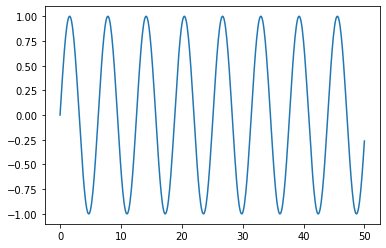

In [5]:
plt.plot(x,y)

In [7]:
df = pd.DataFrame(data=y,index=x,columns=['Sine'])

In [8]:
df

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


In [9]:
len(df)

501

In [10]:
test_percent = 0.1

In [11]:
len(df)*test_percent
#10 percent is 50.1

50.1

In [15]:
test_point = np.round(len(df)*test_percent)

In [16]:
test_point

50.0

In [13]:
test_ind = int(len(df)-test_point)

In [14]:
test_ind

451

In [17]:
train = df.iloc[:test_ind]

In [18]:
test = df.iloc[test_ind:]

In [19]:
len(train)

451

In [20]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
scaler = MinMaxScaler()

In [22]:
scaler.fit(train)

MinMaxScaler()

In [23]:
scaled_train = scaler.transform(train)

In [24]:
scaled_test = scaler.transform(test)

In [25]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [27]:
# help(TimeseriesGenerator)

In [46]:
length = 50
batch_size = 1

generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length = length, batch_size=batch_size)
# generator is length of the scaled_train minus 4
# longer the length, the longer the training time

In [47]:
len(scaled_train)

451

In [48]:
len(generator)

401

In [44]:
X,y = generator[0]

In [49]:
# X

In [50]:
# y

In [51]:
# scaled_train
# Given the first 2 values, predict the next value (basically length=2)

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN,LSTM

In [54]:
n_features = 1

In [61]:
model = Sequential()

model.add(SimpleRNN(50,input_shape=(length,n_features)))
# number of neuron must be related with batch_size

model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

# MSE for continuous functions

In [62]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 50)                2600      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.fit_generator(generator,epochs=5)

c:\users\antho\anaconda3\envs\mytfenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
401/401 [==============================] - 5s 11ms/step - loss: 0.0129
Epoch 2/5
401/401 [==============================] - 5s 12ms/step - loss: 5.5751e-04
Epoch 3/5
401/401 [==============================] - 5s 11ms/step - loss: 5.8292e-04
Epoch 4/5
401/401 [==============================] - 5s 12ms/step - loss: 2.3845e-04
Epoch 5/5
401/401 [==============================] - 5s 11ms/step - loss: 3.3542e-04


<AxesSubplot:>

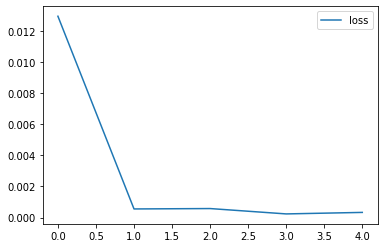

In [64]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [65]:
first_eval_batch = scaled_train[-length:]
# We're going to take the last 25 points from our training set to predict 
# the first point in the future in our test set

In [74]:
first_eval_batch = first_eval_batch.reshape((1,length,n_features))
# in order to pass this into the model, we need to change the shape the model it expects

In [75]:
model.predict(first_eval_batch)
# **We're predicting the scaled version of the first batch**

array([[0.94970167]], dtype=float32)

In [68]:
scaled_test[0]

array([0.94955134])

In [76]:
# We need to make this logic and put this in a for loop to keep moving 25 points

In [84]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [82]:
# predicted_value = [[[99]]]
# np.append(current_batch[:,1:,:],[[[99]]],axis=1)
# So the index basically means based off the dimensions, grab everything from the first dimension,
# grab everything from the third dimension, but in the actual dimension that's holding the data
# go from index 1 all the way to the end, essentially dropping the first original point

In [85]:
# compare with first_eval_batch
# first_eval_batch

In [88]:
test_predictions
# compare this with scaled_test

In [90]:
true_predictions = scaler.inverse_transform(test_predictions)

In [92]:
test['predictions'] = true_predictions


In [125]:
# test

<AxesSubplot:>

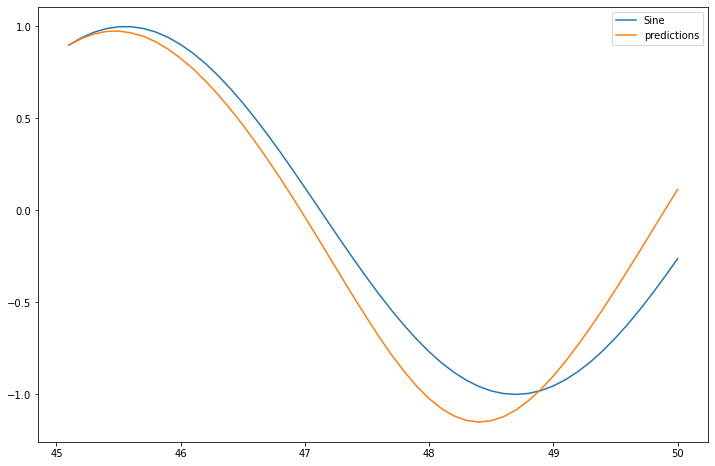

In [95]:
test.plot(figsize=(12,8))

In [ ]:
# predictions aren't perfect. It's interesting to see that our model is mimicking the sine waves
# as we're predicting further into the future, our values starts to deviate because the model is
# predicting off predictions

# First point should be similar, then you use 24 points + 1 predicted point as data to predict 
# the next point and all the way to the end. It makes sense that we're going further off
# because we're essentially doing true forcasting at the very end, but the behavior looks good

In [ ]:
# We can improve with LSTM!!!!!!

In [ ]:
# We use EarlyStopping in conjuction with the fact that we're fitting to the generator
# because passing through the validation data, we need to pass it in the same shape batch/shape
# as the generator is doing. So we need to create 2 generators
# 1 for our training data and 1 for our validation/test data

In [103]:
from tensorflow.keras.callbacks import EarlyStopping

In [108]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [98]:
#Now we create validation data
length = 49
generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,
                               batch_size=1)

validation_generator = TimeseriesGenerator(scaled_test,scaled_test,
                                          length=length,batch_size=1)
# The problem is that our validation data is looking at the exact same length as the
# entirety of our testset. So our scaled_test set must be greater than the length chosen
# for our batches. Can't have start index+length = 50 when our end index is only 49
# We need to redefine our original generator to redefine our length

In [99]:
model = Sequential()

model.add(LSTM(50,input_shape=(length,n_features)))
# number of neuron must be related with batch_size

model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')


In [109]:
model.fit_generator(generator,epochs=20,
                   validation_data=validation_generator,
                   callbacks=[early_stop])

c:\users\antho\anaconda3\envs\mytfenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
402/402 [==============================] - 12s 26ms/step - loss: 0.0135 - val_loss: 3.7472e-05
Epoch 2/20
402/402 [==============================] - 8s 21ms/step - loss: 1.4051e-04 - val_loss: 1.4751e-04
Epoch 3/20
402/402 [==============================] - 8s 19ms/step - loss: 3.4941e-04 - val_loss: 9.3033e-05


In [110]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

c:\users\antho\anaconda3\envs\mytfenv\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


<AxesSubplot:>

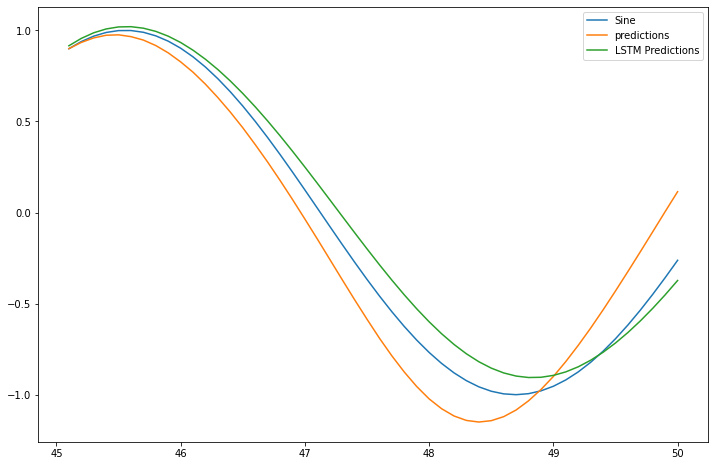

In [112]:
true_predictions = scaler.inverse_transform(test_predictions)
test['LSTM Predictions'] = true_predictions
test.plot(figsize=(12,8))

In [113]:
# LSTM seems to be working quite well towards the end, although it's overshooting in the middle.
# Since we're only focusing on the last end vs the middle. So to solve the middle, since we had a 
# batch size of 50 and length of 49, we may need to either increase the test data and keep the 49/50
# or keep the test data at 50 and lower the length of the batch size.

In [114]:
# If you're satisfied with the performance of the model, let's see if we can forcast the future

In [116]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)
#So we have our full scaled data. Now we create the generator of the full scaled data

In [117]:
generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,
                               length=length,batch_size=1)

In [118]:
model = Sequential()

model.add(LSTM(50,input_shape=(length,n_features)))
# number of neuron must be related with batch_size

model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [119]:
model.fit_generator(generator,epochs=6)

c:\users\antho\anaconda3\envs\mytfenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/6
452/452 [==============================] - 12s 22ms/step - loss: 0.0200
Epoch 2/6
452/452 [==============================] - 9s 20ms/step - loss: 2.6905e-04
Epoch 3/6
452/452 [==============================] - 10s 22ms/step - loss: 1.3953e-04
Epoch 4/6
452/452 [==============================] - 11s 25ms/step - loss: 6.8463e-04
Epoch 5/6
452/452 [==============================] - 11s 25ms/step - loss: 2.3938e-04
Epoch 6/6
452/452 [==============================] - 12s 26ms/step - loss: 3.8201e-05


In [126]:
forecast = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(25):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [127]:
forecast = scaler.inverse_transform(forecast)

In [130]:
forecast_index = np.arange(50.1,52.6,step=0.1)

In [131]:
len(forecast_index)

25

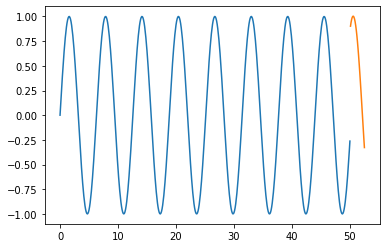

In [133]:
plt.plot(df.index,df['Sine'])
plt.plot(forecast_index,forecast)

In [ ]:
# We can see those 25 points. There's a big gap b/c these are 2 separate series
# There's no line that automatically connects thm